In [98]:
from analysis.analysis import *
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob


def process_gid(gid):
    import pickle

    data = pickle.load(open(f"maps/map_{gid}.pkl", "rb"))
    if len(data["labels"]) > 0:
        return data["F"], data["bounds"], np.array(data["labels"]), data["end_pts"]
    return data["F"], data["bounds"]


def compute_msd(X):
    N = len(X)
    max_t = min(X, key=lambda x: len(x)).shape[0]
    res = []
    for arr in X:
        res.append(np.linalg.norm(arr[1:max_t] - arr[0], axis=1) ** 2)
    return np.arange(1, max_t, 1), np.array(res).sum(axis=0) / N

In [31]:
gid = 151
file = f"/mnt/c/Users/pedro/OneDrive - Johns Hopkins/Documents/Research/hopper/_server/sim_data/defaults/parquets/fulltake_gid{gid}.parquet"

grid_df = read_fulltake(file, scale_position=True)
xy_sets = grid_df.groupby("rid")[["x", "y"]]
xy_sets = [xy_sets.get_group(k).values for k in range(grid_df.rid.max())]

Text(0.5, 0, 'time [hr]')

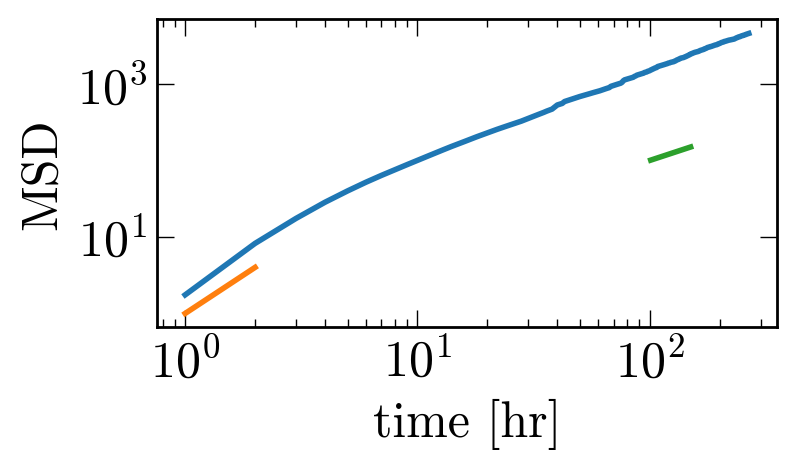

In [116]:
lag_times, msd = compute_msd(xy_sets)
_x = lag_times[:2]
plt.figure(figsize=(4, 2), dpi=200)
plt.plot(lag_times, msd)
plt.plot(_x, _x**2)
_x = lag_times[:50]
plt.plot(_x + 100, _x + 100)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("MSD")
plt.xlabel("time [hr]")

---

# New Geometries

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate


def mixed_two_state_sub(dims, bridge_length, bridge_width):
    """
    Returns a two-state (dumbell-shaped) micropattern, with inside = 0.

    Parameters
    ----------
    dims : np.ndarray of shape (2, 2)
        Specifies the (length, width) dimensions of each basin (left: 0, right: 1) in microns
    bridge_length : float, optional
        Specifies the length of the bridge in microns
    bridge_width : float, optional
        Specifies the width of bridge in microns

    Returns
    -------
    np.ndarray of shape (N_mesh, N_mesh)
        The micropattern.
    """
    # useful variables
    N_mesh = 200
    L_box = 50
    xi = 0.1

    # lattice points
    x, y = np.meshgrid(np.linspace(0, L_box, N_mesh), np.linspace(0, L_box, N_mesh))

    # index of the two squares, used for symmetric positioning
    delta = (bridge_length + dims[:, 0].sum() * 0.5) / (2 * 6)  # in PF.L & halved
    L_bridge = bridge_width / (2 * 6)  # in PF._bridge & halved

    # build the squares
    squares = None
    for k in range(2):
        if k == 0:
            center = L_box / 2 - delta
        else:
            center = L_box / 2 + delta

        xL = center - dims[k][0] / (2 * 6)  # in PF.L & halved
        xR = center + dims[k][0] / (2 * 6)  # in PF.L & halved
        yB = L_box / 2 - dims[k][1] / (2 * 6)  # in PF.L & halved
        yT = L_box / 2 + dims[k][1] / (2 * 6)  # in PF.L & halved
        chi_y = 0.5 * ((1 - np.tanh((y - yB) / xi)) + (1 + np.tanh((y - yT) / xi)))
        chi_x = 0.5 * ((1 - np.tanh((x - xL) / xi)) + (1 + np.tanh((x - xR) / xi)))
        chi = chi_x + chi_y
        chi = np.where(chi > 1, 1, chi)

        if squares is None:
            squares = chi
        else:
            squares += chi

    # build the bridge
    xL = L_box / 2 - delta
    xR = L_box / 2 + delta
    yB, yT = L_box / 2 - L_bridge, L_box / 2 + L_bridge
    chi_y = 0.5 * ((1 - np.tanh((y - yB) / xi)) + (1 + np.tanh((y - yT) / xi)))
    chi_x = 0.5 * ((1 - np.tanh((x - xL) / xi)) + (1 + np.tanh((x - xR) / xi)))
    chi = chi_x + chi_y
    chi = np.where(chi > 1, 1, chi)

    # put squares and bridge together
    mp = (squares - 1) + chi
    mp -= 1
    mp = np.where(mp < 0, 0, mp)
    return mp


def sq_rhom_two_state_sub(dims, bridge_width):
    """
    Returns a two-state (dumbell-shaped) micropattern, with inside = 0.

    Parameters
    ----------
    dims : np.ndarray of shape (2, 2)
        Specifies the (length, width) dimensions of each basin (left: 0, right: 1) in microns
    bridge_width : float, optional
        Specifies the width of bridge in microns

    Returns
    -------
    np.ndarray of shape (N_mesh, N_mesh)
        The micropattern.
    """
    # useful variables
    N_mesh = 200
    L_box = 50
    xi = 0.1

    # lattice points
    x, y = np.meshgrid(np.linspace(0, L_box, N_mesh), np.linspace(0, L_box, N_mesh))

    # index of the two squares, used for symmetric positioning
    bridge_length = 30
    delta = (bridge_length + dims[:, 0].sum() * 0.5) / (2 * 6)  # in PF.L & halved
    L_bridge = bridge_width / (2 * 6)  # in PF._bridge & halved

    # build the squares
    squares = None
    for k in range(2):
        if k == 0:
            center = L_box / 2 - delta
        else:
            center = L_box / 2 + delta

        xL = center - dims[k][0] / (2 * 6)  # in PF.L & halved
        xR = center + dims[k][0] / (2 * 6)  # in PF.L & halved
        yB = L_box / 2 - dims[k][1] / (2 * 6)  # in PF.L & halved
        yT = L_box / 2 + dims[k][1] / (2 * 6)  # in PF.L & halved
        chi_y = 0.5 * ((1 - np.tanh((y - yB) / xi)) + (1 + np.tanh((y - yT) / xi)))
        chi_x = 0.5 * ((1 - np.tanh((x - xL) / xi)) + (1 + np.tanh((x - xR) / xi)))
        chi = chi_x + chi_y
        chi = np.where(chi > 1, 1, chi)
        if k == 1:
            chi = rotate(chi, angle=45, reshape=False)
            chi = np.roll(chi, N_mesh // 12, axis=0)
        if squares is None:
            squares = chi
        else:
            squares += chi

    # build the bridge
    xL = L_box / 2 - delta
    xR = L_box / 2 + delta
    yB, yT = L_box / 2 - L_bridge, L_box / 2 + L_bridge
    chi_y = 0.5 * ((1 - np.tanh((y - yB) / xi)) + (1 + np.tanh((y - yT) / xi)))
    chi_x = 0.5 * ((1 - np.tanh((x - xL) / xi)) + (1 + np.tanh((x - xR) / xi)))
    chi = chi_x + chi_y
    chi = np.where(chi > 1, 1, chi)

    # put squares and bridge together
    mp = (squares - 1) + chi
    mp -= 1
    mp = np.where(mp < 0, 0, mp)
    return mp

def rhom_two_state_sub(dims):
    """
    Returns a two-state (dumbell-shaped) micropattern, with inside = 0.

    Parameters
    ----------
    dims : np.ndarray of shape (2, 2)
        Specifies the (length, width) dimensions of each basin (left: 0, right: 1) in microns
    bridge_width : float, optional
        Specifies the width of bridge in microns

    Returns
    -------
    np.ndarray of shape (N_mesh, N_mesh)
        The micropattern.
    """
    # useful variables
    N_mesh = 200
    L_box = 50
    xi = 0.1

    # lattice points
    x, y = np.meshgrid(np.linspace(0, L_box, N_mesh), np.linspace(0, L_box, N_mesh))

    # index of the two squares, used for symmetric positioning
    bridge_length = 50
    bridge_width = 10
    delta = (bridge_length + dims[:, 0].sum() * 0.5) / (2 * 6)  # in PF.L & halved
    L_bridge = bridge_width / (2 * 6)  # in PF._bridge & halved

    # build the squares
    squares = None
    for k in range(2):
        if k == 0:
            center = L_box / 2 - delta
        else:
            center = L_box / 2 + delta

        xL = center - dims[k][0] / (2 * 6)  # in PF.L & halved
        xR = center + dims[k][0] / (2 * 6)  # in PF.L & halved
        yB = L_box / 2 - dims[k][1] / (2 * 6)  # in PF.L & halved
        yT = L_box / 2 + dims[k][1] / (2 * 6)  # in PF.L & halved
        chi_y = 0.5 * ((1 - np.tanh((y - yB) / xi)) + (1 + np.tanh((y - yT) / xi)))
        chi_x = 0.5 * ((1 - np.tanh((x - xL) / xi)) + (1 + np.tanh((x - xR) / xi)))
        chi = chi_x + chi_y
        chi = np.where(chi > 1, 1, chi)
        chi = rotate(chi, angle=45, reshape=False)
        q = 10
        q = -q if k == 0 else q
        chi = np.roll(chi, N_mesh // q, axis=0)
        if squares is None:
            squares = chi
        else:
            squares += chi

    # build the bridge
    xL = L_box / 2 - delta
    xR = L_box / 2 + delta
    yB, yT = L_box / 2 - L_bridge, L_box / 2 + L_bridge
    chi_y = 0.5 * ((1 - np.tanh((y - yB) / xi)) + (1 + np.tanh((y - yT) / xi)))
    chi_x = 0.5 * ((1 - np.tanh((x - xL) / xi)) + (1 + np.tanh((x - xR) / xi)))
    chi = chi_x + chi_y
    chi = np.where(chi > 1, 1, chi)

    # put squares and bridge together
    mp = (squares - 1) + chi
    mp -= 1
    mp = np.where(mp < 0, 0, mp)
    return mp

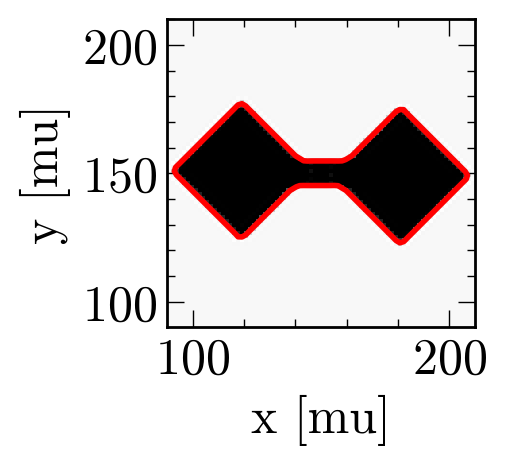

In [177]:
chi = mixed_two_state_sub(
    np.array([[38, 38], [38, 38]]), bridge_length=15, bridge_width=8
)

chi = sq_rhom_two_state_sub(np.array([[38, 38], [38, 38]]), bridge_width=8)

chi = rhom_two_state_sub(np.array([[38, 38], [38, 38]]))


plt.figure(dpi=200)
plt.imshow(chi, origin="lower", extent=[0, 50 * 6, 0, 50 * 6], cmap="Greys_r")
plt.contour(
    chi,
    levels=[0.5],
    origin="lower",
    extent=[0, 50 * 6, 0, 50 * 6],
    colors="red",
    linewidths=2,
)
plt.xlabel("x [mu]")
plt.ylabel("y [mu]")
plt.xlim((90, 210))
plt.ylim((90, 210))
plt.show()